In [2]:
import os
from pathlib import Path

import pandas as pd
import seaborn as sb
import spacy
import wordcloud

In [3]:
# Replace this with the path to the font to use on your system
font_path = "/usr/share/fonts/noto-cjk/NotoSansCJK-Regular.ttc"

In [4]:
def collect_policies(path: Path) -> list[str]:
    text: list[str] = []
    for filename in os.listdir(path):
        if filename.split(".")[-1]!="txt":
            continue
        with open(path/filename,"r") as file:
            text.append(file.read())
    return text

In [5]:
df = pd.read_csv("../policy_corpus/privacy_links_df.csv")

In [6]:
df.head()

,domain,privacy_link,hash,init_language,valid_language,text_content
0,www.us-onlinestore.com,https://www.us-onlinestore.com/law.html#area-p...,9ac6380d1d17249bf50dd2f9e43c545b25ea820e2c28e5...,Japan,NaN,NaN
1,enhance.co.jp,https://enhance.co.jp/privacy-policy/,0fb0f105dfa22b83c4c15d0665ce7c97f7c9577c225b5b...,Japan,NaN,NaN
2,rizapgroup.com,https://rizapgroup.com/privacy,1de0c851c94d9d92fc1ec03635321420fb60c159661ec1...,Japan,NaN,NaN
3,asajikan.jp,https://asajikan.jp/privacy,724587d0bdf7fa450cb3bf22b397ced291053b4db05377...,Japan,NaN,NaN
4,mocom.tv,https://mocom.tv/payment_policy.phtml,2e8b98375e71893f56667adcd62d32256b05dbf126571d...,Japan,NaN,NaN


In [10]:
ko_pol = collect_policies(Path("../crawler/policies/sample_policies_korean"))
ja_pol = collect_policies(Path("../crawler/policies/sample_policies_japanese"))
zh_pol = collect_policies(Path("../crawler/policies/sample_policies_chinese"))

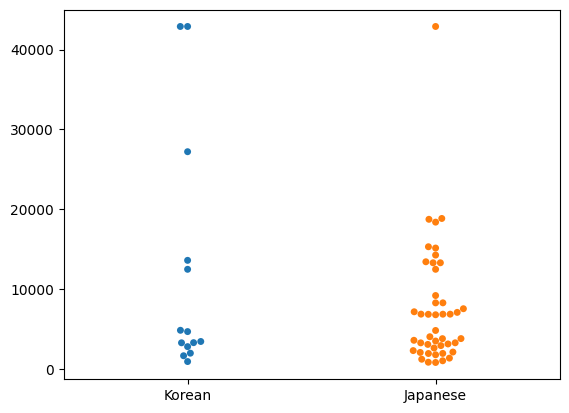

In [11]:
# Plot of Korean vs Japanese privacy policy lengths
sb.swarmplot({"Korean":[len(p) for p in ko_pol],"Japanese": [len(p) for p in ja_pol]});

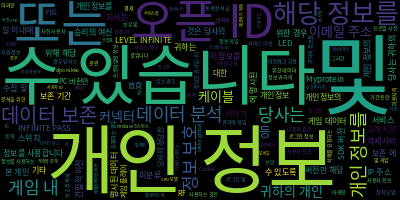

In [12]:
# Korean
cloud=wordcloud.WordCloud(font_path=font_path)
cloud.generate(text="\n".join(ko_pol))
cloud.to_image()

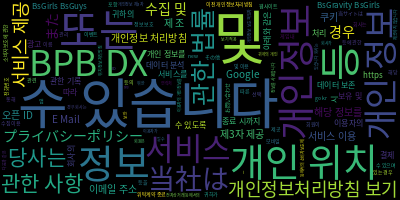

In [13]:
# Japanese
cloud=wordcloud.WordCloud(font_path=font_path)
cloud.generate(text="\n".join(ja_pol))
cloud.to_image()